In [ ]:
# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import pprint

#from tqdm import tqdm
#tqdm.pandas()

In [4]:
import pyLDAvis
import pyLDAvis.gensim

#from gensim.matutils import Sparse2Corpus
from gensim.models import LdaModel, TfidfModel, LsiModel
from gensim.corpora import Dictionary

import spacy
from textblob import TextBlob

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [5]:
filepath = "../data/data_airplane_crash_20200624.pkl"

import pickle
with open(filepath, 'rb') as f:
    df = pickle.load(f)

In [6]:
data = df[["alpha2_country", "Summary"]]

# NLP

In [ ]:
## Dealing with nan

In [7]:
data = data.fillna("-")

In [ ]:
## Preprocessing

In [8]:
#%%time
nlp = spacy.load("en_core_web_md")
#16sec

In [9]:
def preprocess_spacy(sent):
    doc = str(sent)
    doc = nlp(sent.lower())
    prep = [not(token.like_num or token.is_punct or token.is_stop) for token in doc]
    
    arr = np.array(doc)
    arr_clean = arr[prep]
    
    word_lem = [token.lemma_ for token in arr_clean]
    
    return word_lem

In [10]:
#%%time
data["preprocessed_text_spacy"] = data["Summary"].apply(preprocess_spacy)
#40sec

## Sentiment Analysis

In [11]:
data["polarity"] = data["Summary"].apply(lambda x: TextBlob(x).sentiment.polarity)
data["subjectivity"] = data["Summary"].apply(lambda x: TextBlob(x).sentiment.subjectivity)

No handles with labels found to put in legend.


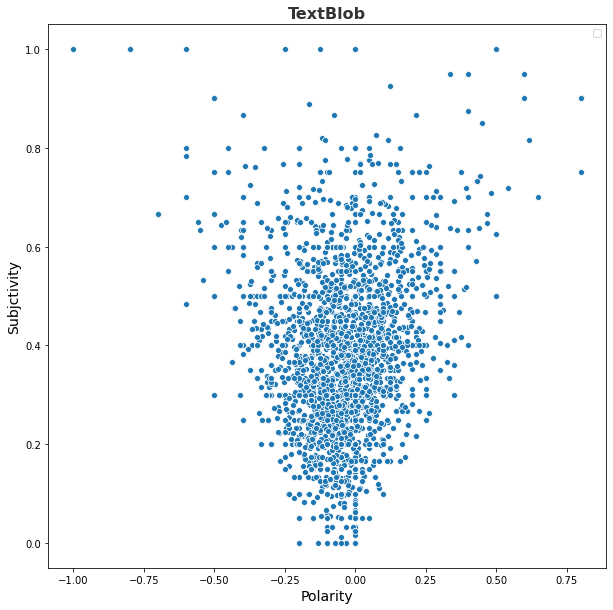

In [12]:
plt.figure(figsize=(10,10))

sns.scatterplot(data["polarity"], data["subjectivity"])

plt.title('TextBlob', fontweight='bold', color = 'black', fontsize='16', alpha=0.8)
plt.xlabel('Polarity', fontsize='14')
plt.ylabel('Subjctivity', fontsize='14')
plt.legend()

plt.show()

In [13]:
def see_comment(df, pol_min=-1, pol_max=1, sub_min=0, sub_max=1):
    data_see = df.loc[(df["polarity"] > pol_min) & (df["polarity"] < pol_max) & (df["subjectivity"] > sub_min) & (df["subjectivity"] < sub_max)]
    
    rand_ind = np.random.choice(data_see.index,5)
    for index in rand_ind:
        print(data.loc[index, "Summary"])
        print()


In [14]:
see_comment(data, 0.3, 1)

Controlled flight into terrain, 53 km south of Shakhtyorsk. The crew descended below a safe altitude during the approach.

Crashed into the Sierra de Luquillo mountains. The vectoring of the aircraft by a ATC trainee into mountainous terrain under IFR  conditions without adequate clearance altitude.

Struck trees on the northwest slope of Pilot Knob Mountain, and impacted a rock cliff, after which the aircraft fell 38ft, becoming lodged between trees. The captain exceeded his clearance limits and flew the aircraft into a severe "lee side" mountain downdraft at an altitude insufficient for recovery.

The cargo plane crashed in strong winds

The air taxi crashed into Puget Sound as it attempted to take off.



In [ ]:
## TFIDF GENSIM

In [15]:
corpus = data["preprocessed_text_spacy"]
id2word = Dictionary(corpus)
bow = [id2word.doc2bow(line) for line in corpus]
tf_idf_model = TfidfModel(bow)
tf_idf_gensim = tf_idf_model[bow]

In [ ]:
## LSI

In [ ]:
lsi = LsiModel(corpus=tf_idf_gensim,
               id2word=id2word,
               num_topics=10)

#lsi.print_topics()
#pprint.pprint(lsi.print_topics())

In [ ]:
## LDA

In [16]:
lda = LdaModel(corpus=tf_idf_gensim,
               id2word=id2word,
               num_topics=10,
               passes=10)

#pprint.pprint(lda.print_topics())

In [ ]:
## LDA Visualisation (bow)

In [ ]:
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(topic_model=lda,
                              corpus=bow, 
                              dictionary=id2word)

vis

## LDA Visualisation (tfidf)

In [17]:
pyLDAvis.enable_notebook()

vis2 = pyLDAvis.gensim.prepare(topic_model=lda,
                              corpus=tf_idf_gensim, 
                              dictionary=id2word)

vis2

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.281762 -0.048489       1        1  33.781250
9      0.176192  0.150146       2        1  17.556519
0      0.084981 -0.117121       3        1  11.892738
8      0.003216  0.008998       4        1   6.588226
3     -0.069634  0.004599       5        1   5.934691
1     -0.111350  0.021603       6        1   5.897930
2     -0.086812 -0.029335       7        1   5.801232
4     -0.064672 -0.038865       8        1   5.439876
5     -0.109647  0.028618       9        1   3.672020
7     -0.104037  0.019845      10        1   3.435521, topic_info=            Term       Freq      Total Category  logprob  loglift
1551  helicopter  40.000000  40.000000  Default  30.0000  30.0000
210           en  54.000000  54.000000  Default  29.0000  29.0000
213        route  57.000000  57.000000  Default  28.0000  28.0000
100        shoot  25.000000  25.000000  Default  27.0000  27.0000
89        engine  87.000000  87.000000  Default  26.0000  26.0000
...          ...        ...        ...      ...      ...      ...
389       nearby   2.293369   3.787832  Topic10  -5.5519   2.8692
594        fence   1.980561   8.005931  Topic10  -5.6985   1.9742
105        black   1.524805   4.445170  Topic10  -5.9601   2.3010
1435         oil   2.141605  10.997259  Topic10  -5.6204   1.7349
4175     copilot   1.410892   7.209284  Topic10  -6.0377   1.7399

[554 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.592078          
0         2  0.213806          
0         3  0.115126          
0         4  0.032893          
0         5  0.016447          
...     ...       ...       ...
767       1  0.305960  wreckage
767       3  0.183576  wreckage
767       4  0.061192  wreckage
767       5  0.367152  wreckage
767       7  0.061192  wreckage

[915 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 10, 1, 9, 4, 2, 3, 5, 6, 8])